# Import

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Object Detection

In [1]:
def detect_shapes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    imgBlur = cv2.GaussianBlur(gray, (7, 7), 1.5)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(imgBlur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)

    # Find contours with hierarchy
    contours, hierarchy = cv2.findContours(adaptive_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        # Only process the outermost contours (where hierarchy[0][i][3] == -1)
        if hierarchy[0][i][3] == -1:
            # Filter out small contours by area
            if cv2.contourArea(contour) < 500:
                continue

            approx = cv2.approxPolyDP(contour, 0.03 * cv2.arcLength(contour, True), True)
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            if len(approx) == 3:
                shape_name = 'Triangle'
            elif len(approx) == 4:
                if 0.95 <= aspect_ratio <= 1.05:
                    shape_name = 'Square'
                else:
                    shape_name = 'Rectangle'
            elif len(approx) == 5:
                shape_name = 'Pentagon'
            elif len(approx) == 6:
                shape_name = 'Hexagon'
            else:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter != 0:
                    circularity = 4 * np.pi * (area / (perimeter * perimeter))
                    shape_name = 'Circle' if circularity > 0.8 else 'Ellipse'
                else:
                    shape_name = 'Unknown'

            # Draw a red contour around the shape
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 2)

            # Add a red background rectangle for the text
            cv2.rectangle(img, (x, y - 20), (x + len(shape_name) * 12, y), (0, 0, 255), -1)
            cv2.putText(img, shape_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return img

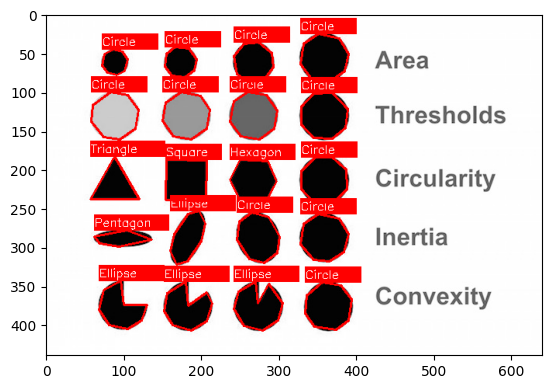

In [44]:
# Example usage
image_path = 'img/BlobTest.jpg'
result_image = detect_shapes(image_path)
# Display the images
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Inpainting Man

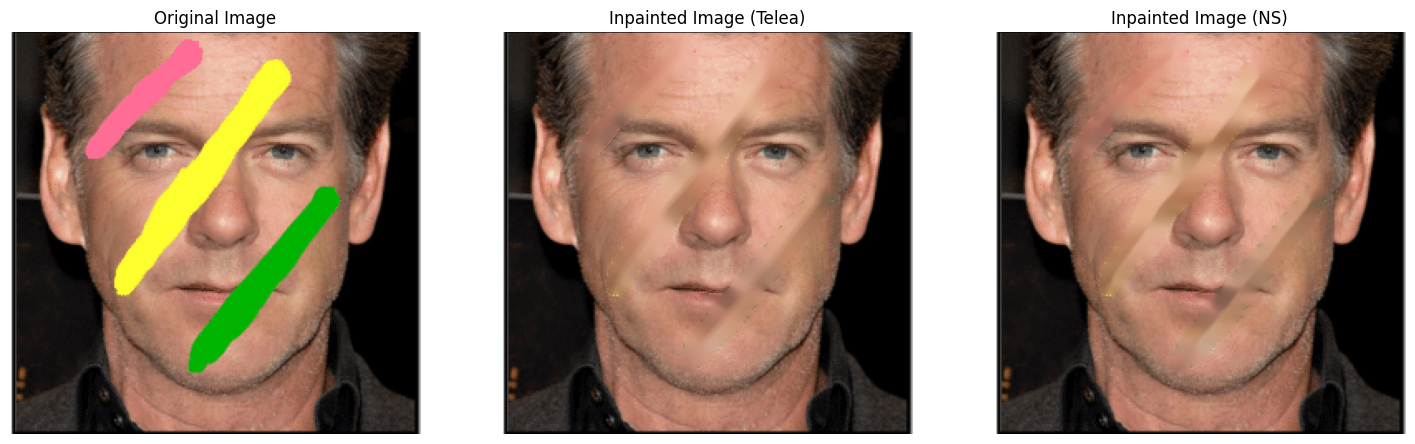

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'Inpainting-Man.bmp'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color ranges for the marks (pink, yellow, green)
lower_pink = np.array([160, 100, 100])
upper_pink = np.array([180, 255, 255])
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
lower_green = np.array([40, 100, 100])
upper_green = np.array([70, 255, 255])

# Create masks for each color
mask_pink = cv2.inRange(hsv_image, lower_pink, upper_pink)
mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

# Combine the masks
mask = cv2.bitwise_or(mask_pink, mask_yellow)
mask = cv2.bitwise_or(mask, mask_green)

# Refine the mask with morphological operations
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Try both inpainting methods
inpainted_image_telea = cv2.inpaint(image, mask, 5, cv2.INPAINT_TELEA)
inpainted_image_ns = cv2.inpaint(image, mask, 5, cv2.INPAINT_NS)

# Convert BGR images to RGB for displaying
inpainted_image_telea_rgb = cv2.cvtColor(inpainted_image_telea, cv2.COLOR_BGR2RGB)
inpainted_image_ns_rgb = cv2.cvtColor(inpainted_image_ns, cv2.COLOR_BGR2RGB)

# Plot the original and inpainted images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Inpainted Image (Telea)')
plt.imshow(inpainted_image_telea_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Inpainted Image (NS)')
plt.imshow(inpainted_image_ns_rgb)
plt.axis('off')

plt.show()

# 3. Face Detection

Number of faces detected: 12


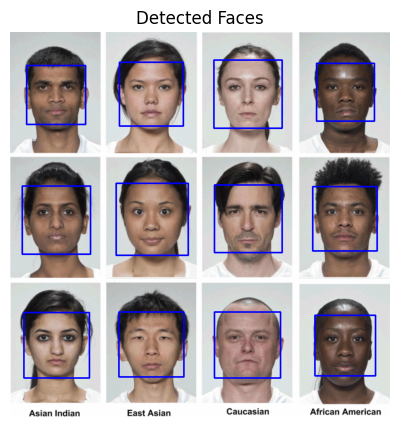

In [9]:
import cv2
import matplotlib.pyplot as plt


def detect_facesas(image_path):
    # Load the image
    # image = cv2.imread(image_path)
    frame = cv2.VideoCapture(image_path)
    ret, image = frame.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=7,  # Increase to reduce false positives
        minSize=(30, 30)  # Keep small to detect smaller faces
    )

    # Filter out small detections
    min_face_size = 100  # Minimum size of what we consider a valid face
    faces = [face for face in faces if face[2] > min_face_size and face[3] > min_face_size]

    # Print the number of faces detected
    print(f"Number of faces detected: {len(faces)}")

    # Draw rectangles around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Detected Faces')
    plt.show()

# Input path to the photo
image_path = 'Multi_Racial_Face_he3-2321570-696x706.gif'  # Replace with the path to your image
detect_facesas(image_path)


In [8]:
%pip install deepface

     ---------------------------------------- 0.0/88.4 kB ? eta -:--:--
     ---------------------------------------- 88.4/88.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/105.5 kB ? eta -:--:--
   ---------------------------------------- 105.5/105.5 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/101.7 kB ? eta -:--:--
   ---------------------------------------- 101.7/101.7 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/84.4 kB ? eta -:--:--
   ---------------------------------------- 84.4/84.4 kB 2.4 MB/s